In [274]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import figure
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

In [199]:
df_game = pd.read_csv('dados_case_sr.csv', sep=';', error_bad_lines=False)
df_game.head()

,Unnamed: 0,device_id,event_date,creation_date,app,platform,partner,country,iap_purchases,iap_revenue,ads_revenue,ad_impressions
0,1,484c0f6c716b62fbdd651b48448632c6,2022-01-05,2020-12-31,Football Simulator,android,Organic,Canada,1,"4,18164547135849","0,00268264452",6
1,2,54a09dd2892b768a6ae566e0f4ee61e1,2022-05-29,2022-05-01,Football Simulator,android,Paid,Pakistan,1,"2,35950024395138","0,0652680554058738",3
2,3,be59fd534f61e87e6c617fa50edde27e,2022-04-02,2022-03-30,Football Simulator,ios,Organic,United States,1,"2,22307474997593","0,03285518396",28
3,4,af4830573c2ac1d4efc538d16d645b31,2022-03-25,2022-03-25,Football Simulator,android,Organic,Argentina,1,"3,93345382196093","0,00025961076",7
4,5,13c70063c611c94b1f5051e4eba6f5c0,2022-03-24,2022-03-12,Football Simulator,android,Paid,United States,1,"3,23837452336857","0,00066344972",4


## Verificando a necessidade de ajustes na base

#### Analisando o shape da base:

In [202]:
print(df_game.shape[0], 'X' , df_game.shape[1])

9067690 X 12


In [203]:
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9067690 entries, 0 to 9067689
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   device_id       object
 2   event_date      object
 3   creation_date   object
 4   app             object
 5   platform        object
 6   partner         object
 7   country         object
 8   iap_purchases   int64 
 9   iap_revenue     object
 10  ads_revenue     object
 11  ad_impressions  int64 
dtypes: int64(3), object(9)
memory usage: 830.2+ MB


#### Ajustes necessarios:
* deletar primeira coluna, ela na verdade é somente um index
* **event_date** e **creation_date** tem que ser ajustada para datetime , autalmente está sendo tratada como object
* **iap_revenue** e **ads_revenue** estão como object , tem que deixar como float. Será necessario mudar a pontuação usada
* deixar o resto como string

### Verificando a existencia de duplicadas

In [204]:
df_game.isna().sum()

Unnamed: 0            0
device_id             0
event_date            0
creation_date         0
app                   0
platform              0
partner               0
country           20285
iap_purchases         0
iap_revenue           0
ads_revenue           0
ad_impressions        0
dtype: int64

In [205]:
dados_nulos = df_game.isna().sum()
dados_totais = df_game.shape[0]
percentual_de_zeros = (dados_nulos / dados_totais)*100
print(percentual_de_zeros)

Unnamed: 0        0.000000
device_id         0.000000
event_date        0.000000
creation_date     0.000000
app               0.000000
platform          0.000000
partner           0.000000
country           0.223706
iap_purchases     0.000000
iap_revenue       0.000000
ads_revenue       0.000000
ad_impressions    0.000000
dtype: float64


Apenas a feature **Country** possui dados faltosos. Eles representam apenas 0,22% do total, logo não deverá ter tanto impacto deleta-los

#### Realizando ajustes 

In [206]:
# Deletar coluna de axis
df_game = df_game.drop('Unnamed: 0' , axis=1)

In [207]:
df_game.head()

,device_id,event_date,creation_date,app,platform,partner,country,iap_purchases,iap_revenue,ads_revenue,ad_impressions
0,484c0f6c716b62fbdd651b48448632c6,2022-01-05,2020-12-31,Football Simulator,android,Organic,Canada,1,"4,18164547135849","0,00268264452",6
1,54a09dd2892b768a6ae566e0f4ee61e1,2022-05-29,2022-05-01,Football Simulator,android,Paid,Pakistan,1,"2,35950024395138","0,0652680554058738",3
2,be59fd534f61e87e6c617fa50edde27e,2022-04-02,2022-03-30,Football Simulator,ios,Organic,United States,1,"2,22307474997593","0,03285518396",28
3,af4830573c2ac1d4efc538d16d645b31,2022-03-25,2022-03-25,Football Simulator,android,Organic,Argentina,1,"3,93345382196093","0,00025961076",7
4,13c70063c611c94b1f5051e4eba6f5c0,2022-03-24,2022-03-12,Football Simulator,android,Paid,United States,1,"3,23837452336857","0,00066344972",4


In [208]:
# Arrumando colunas de data
df_game['event_date'] = pd.to_datetime(df_game['event_date'])
df_game['creation_date'] = pd.to_datetime(df_game['creation_date'])

In [209]:
# Arrumando as valores iap_revenue e ads_revenue para formato de valor
df_game['iap_revenue'] = df_game['iap_revenue'].str.replace(',' , '.').astype(float)
df_game['ads_revenue'] = df_game['ads_revenue'].str.replace (',' , '.').astype(float)


In [210]:
# deletando linhas com country vazio
df_game.dropna(inplace = True)

In [211]:
df_game['revenue_total'] = df_game['iap_revenue'] + df_game['ads_revenue']

#### Filtrando os paises com pouca participação ( usaremos pareto para filtrar)

In [212]:
df_pais_jogadores = df_game.groupby('country').device_id.count()
df_pais_jogadores = pd.DataFrame(df_pais_jogadores).reset_index() 
df_pais_jogadores = df_pais_jogadores.sort_values("device_id" , ascending=False)
df_pais_jogadores

,country,device_id
223,United States,1986595
29,Brazil,697561
78,Germany,606476
96,India,526984
222,United Kingdom,490789
...,...,...
192,Solomon Islands,3
141,Montserrat,2
110,Kiribati,2
174,Saint Helena,2


In [213]:
df_pais_jogadores['percent_acumulada'] = df_pais_jogadores['device_id'].cumsum() / df_pais_jogadores['device_id'].sum() *100

In [214]:
ajustar_paises = df_pais_jogadores.loc[df_pais_jogadores['percent_acumulada']>=81]
ajustar_paises = ajustar_paises['country'].tolist()

##### Ajustando na base base geral

In [215]:
for n in df_game['country']:
    if n in ajustar_paises:
        df_game['country'] = df_game['country'].replace(n, 'outros')

In [246]:
df_game.head()

,device_id,event_date,creation_date,app,platform,partner,country,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total
0,484c0f6c716b62fbdd651b48448632c6,2022-01-05,2020-12-31,Football Simulator,android,Organic,Canada,1,4.181645,0.002683,6,4.184328
1,54a09dd2892b768a6ae566e0f4ee61e1,2022-05-29,2022-05-01,Football Simulator,android,Paid,outros,1,2.359500,0.065268,3,2.424768
2,be59fd534f61e87e6c617fa50edde27e,2022-04-02,2022-03-30,Football Simulator,ios,Organic,United States,1,2.223075,0.032855,28,2.255930
3,af4830573c2ac1d4efc538d16d645b31,2022-03-25,2022-03-25,Football Simulator,android,Organic,Argentina,1,3.933454,0.000260,7,3.933713
4,13c70063c611c94b1f5051e4eba6f5c0,2022-03-24,2022-03-12,Football Simulator,android,Paid,United States,1,3.238375,0.000663,4,3.239038


##### Criando a base de 2022 

In [217]:
df_game_2022 = df_game.loc[df_game['creation_date']>= '2022-01-01']

## Analisando os dados

## 1) Plataforma

#### Número de jogadores

In [220]:
df_plat = df_game_2022['platform'].value_counts() / df_game_2022.shape[0]
df_plat

android    0.725771
ios        0.274199
amazon     0.000030
Name: platform, dtype: float64

In [221]:
df_plat2 = df_game_2022.groupby('platform').device_id.count()
df_plat2

platform
amazon         224
android    5347430
ios        2020278
Name: device_id, dtype: int64

Conclusão : Android é a sistema operacional com mais dowloads, cerca de 72% (5 Mi devices) , seguido por IOS 27% (2 Mi devices). Amazon quase não é relevante (213 devices)

#### Número de compras

In [223]:
df_plat_compras = df_game_2022.groupby('platform').iap_purchases.sum()
df_plat_compras

platform
amazon         224
android    5419986
ios        2055518
Name: iap_purchases, dtype: int64

Conclusão : Android é a sistema operacional onde os jogadores mais realizaram compras, cerca de 5.4 Mi de compras.

#### Plataforma com maior revenue

In [224]:
round(df_game_2022.loc[df_game_2022['platform'] == 'amazon'].revenue_total.sum() ,2)

668.85

In [225]:
round(df_game_2022.loc[df_game_2022['platform'] == 'android'].revenue_total.sum(),2)

15906425.92

In [226]:
round(df_game_2022.loc[df_game_2022['platform'] == 'ios'].revenue_total.sum(),2)

6043605.83

Conclusão : Android é a sistema operacional que trouxe mais revenue , cerca de BRL 15.9 Mi , IOS trouxe BRL 6 Mi

#### Retorno médio do jogador por plataforma

In [227]:
round(df_game_2022.loc[df_game_2022['platform'] == 'android'].revenue_total.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'android'].device_id.count()

2.9745926398288525

In [228]:
round(df_game_2022.loc[df_game_2022['platform'] == 'ios'].revenue_total.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'ios'].device_id.count()

2.9914723765739173

Conclusão : o ganho médio com IOS é levente maior que com Android

#### Ticket médio do jogador

In [229]:
round(df_game_2022.loc[df_game_2022['platform'] == 'android'].iap_purchases.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'android'].device_id.count()

1.01356838705696

In [230]:
round(df_game_2022.loc[df_game_2022['platform'] == 'ios'].iap_purchases.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'ios'].device_id.count()

1.0174431439633556

In [231]:
round(df_game_2022.loc[df_game_2022['platform'] == 'amazon'].iap_purchases.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'amazon'].device_id.count()

1.0

Conclusão : o ticket médio dé praticamente o mesmo independente da plataforma 

#### Impressoes de anuncio por jogador em cada plataforma

In [232]:
round(df_game_2022.loc[df_game_2022['platform'] == 'android'].ad_impressions.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'android'].device_id.count()

13.333372292858439

In [233]:
round(df_game_2022.loc[df_game_2022['platform'] == 'ios'].ad_impressions.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'ios'].device_id.count()

10.64888545041821

In [234]:
round(df_game_2022.loc[df_game_2022['platform'] == 'amazon'].ad_impressions.sum(),2) / df_game_2022.loc[df_game_2022['platform'] == 'amazon'].device_id.count()

3.0

Conclusão : Jogadores que utilziam como plataforma o android são mais impactados por anuncios

In [159]:
# quem fica mais tempo jogando ?

## 2) Country 

#### País com maior número de dowloads

In [235]:
df_pais_jogadores = df_game_2022.groupby('country').device_id.count()
df_pais_jogadores = pd.DataFrame(df_pais_jogadores).reset_index() 
df_pais_jogadores = df_pais_jogadores.sort_values("device_id" , ascending=False)
df_pais_jogadores

,country,device_id
18,United States,1564465
19,outros,1513875
2,Brazil,609061
7,India,483780
6,Germany,455712
17,United Kingdom,358499
9,Mexico,299765
8,Italy,265196
5,France,264786
12,Poland,223249


Conclusão: EUA lideram em número de downloads, ficando acima do que a soma de 230 paises. O Brasil fica em 3 lugar, com um pouco menos que a metade do numero dos EUA

In [237]:
df_pais_valor = df_game_2022.groupby('country').revenue_total.sum()
df_pais_valor = pd.DataFrame(df_pais_valor).reset_index() 
df_pais_valor = df_pais_valor.sort_values("revenue_total" , ascending=False)
df_pais_valor

,country,revenue_total
18,United States,4.751085e+06
19,outros,4.496616e+06
2,Brazil,1.787848e+06
7,India,1.419299e+06
6,Germany,1.365076e+06
17,United Kingdom,1.070884e+06
9,Mexico,8.816270e+05
5,France,7.885887e+05
8,Italy,7.858190e+05
12,Poland,6.595693e+05


Conclusão: EUA lideram em revenue

## 3)Partner

#### Qual partner trouxe mais jogadores ?

In [238]:
df_partner = df_game_2022['partner'].value_counts() / df_game_2022.shape[0]
df_partner

Paid       0.571598
Organic    0.428402
Name: partner, dtype: float64

Conclusão: Há mais jogadores de origem paga

#### Qual partner traz mais revenue ?

In [239]:
round(df_game_2022.loc[df_game_2022['partner'] == 'Paid'].revenue_total.sum(),2)

12553804.26

In [240]:
round(df_game_2022.loc[df_game_2022['partner'] == 'Organic'].revenue_total.sum(),2)

9396896.34

Conclusão : Jogadores que vieram via **user acquisition** gastam mais

#### Qual retorno médio por jogador trazido por cada partner?

In [241]:
round(df_game_2022.loc[df_game_2022['partner'] == 'Paid'].revenue_total.sum(),2) / df_game_2022.loc[df_game_2022['partner'] == 'Paid'].device_id.count()

2.980844147194356

In [242]:
round(df_game_2022.loc[df_game_2022['partner'] == 'Organic'].revenue_total.sum(),2) / df_game_2022.loc[df_game_2022['partner'] == 'Organic'].device_id.count()

2.9770562142971873

Conclusão : O retorno médio por jogador é praticamente igual, idependente da origem dele

In [ ]:
##### Criando bases com dummies

In [244]:

# com dummies para categoricas
df_game2 = pd.get_dummies(df_game , columns=['platform' , 'partner' , 'country'])

# deixar no formato mes
df_game2['event_date'] = pd.to_datetime(df_game2['event_date'],format="%Y-%m-%D")
df_game2['event_date'] = [i.strftime('%Y-%m') for i in df_game2['event_date']]
df_game2['creation_date'] = pd.to_datetime(df_game2['creation_date'],format="%Y-%m-%D")
df_game2['creation_date'] = [i.strftime('%Y-%m') for i in df_game2['creation_date']]

#criando base 2022
df_game2_2022 = df_game2.loc[df_game2['creation_date']>= '2022-01']

# criando novas bases
df_game2.to_csv('game_mes.csv', index=False)
df_game2_2022.to_csv('game_mes22.csv', index=False)

In [247]:
df_game2.head()

,device_id,event_date,creation_date,app,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total,platform_amazon,...,country_Netherlands,country_Philippines,country_Poland,country_Russian Federation,country_Spain,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_outros
0,484c0f6c716b62fbdd651b48448632c6,2022-01,2020-12,Football Simulator,1,4.181645,0.002683,6,4.184328,0,...,0,0,0,0,0,0,0,0,0,0
1,54a09dd2892b768a6ae566e0f4ee61e1,2022-05,2022-05,Football Simulator,1,2.359500,0.065268,3,2.424768,0,...,0,0,0,0,0,0,0,0,0,1
2,be59fd534f61e87e6c617fa50edde27e,2022-04,2022-03,Football Simulator,1,2.223075,0.032855,28,2.255930,0,...,0,0,0,0,0,0,0,0,1,0
3,af4830573c2ac1d4efc538d16d645b31,2022-03,2022-03,Football Simulator,1,3.933454,0.000260,7,3.933713,0,...,0,0,0,0,0,0,0,0,0,0
4,13c70063c611c94b1f5051e4eba6f5c0,2022-03,2022-03,Football Simulator,1,3.238375,0.000663,4,3.239038,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
# agrupar por data de primeiro login
#df_dt_login = df_game_.groupby('creation_date').sum()
#df_dt_login

- agrupar resultados por mes
- fazer alguns graficos para analisar o movimento
- analise distribuições 
- modelo de 3 meses    


### Criando base final que será usada para analise gráfica

In [248]:
df_game_mes22 = pd.read_csv('game_mes22.csv', sep=',', error_bad_lines=False)
df_game_mes22.head()

,device_id,event_date,creation_date,app,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total,platform_amazon,...,country_Netherlands,country_Philippines,country_Poland,country_Russian Federation,country_Spain,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_outros
0,54a09dd2892b768a6ae566e0f4ee61e1,2022-05,2022-05,Football Simulator,1,2.359500,0.065268,3,2.424768,0,...,0,0,0,0,0,0,0,0,0,1
1,be59fd534f61e87e6c617fa50edde27e,2022-04,2022-03,Football Simulator,1,2.223075,0.032855,28,2.255930,0,...,0,0,0,0,0,0,0,0,1,0
2,af4830573c2ac1d4efc538d16d645b31,2022-03,2022-03,Football Simulator,1,3.933454,0.000260,7,3.933713,0,...,0,0,0,0,0,0,0,0,0,0
3,13c70063c611c94b1f5051e4eba6f5c0,2022-03,2022-03,Football Simulator,1,3.238375,0.000663,4,3.239038,0,...,0,0,0,0,0,0,0,0,1,0
4,9910918abee08a5d5156c3f49e1d1cdb,2022-04,2022-03,Football Simulator,1,1.545516,0.006923,12,1.552438,0,...,0,0,0,0,0,0,0,0,1,0


In [250]:
df_dt_login = df_game_mes22.groupby('creation_date').sum().reset_index()
df_dt_login

,creation_date,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total,platform_amazon,platform_android,platform_ios,partner_Organic,...,country_Netherlands,country_Philippines,country_Poland,country_Russian Federation,country_Spain,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_outros
0,2022-01,1408630,4.122853e+06,30608.768073,18370403,4.153461e+06,55,912991,478084,531397,...,13183,18422,76621,15337,14846,2567,20254,70087,443600,218259
1,2022-02,1119581,3.267063e+06,24682.290490,14060658,3.291745e+06,39,697277,405702,521808,...,14043,30529,24726,10464,18726,7356,15330,66071,339244,173739
2,2022-03,962517,2.812541e+06,20849.912890,11927006,2.833391e+06,37,596970,350317,413177,...,7899,18019,28053,5425,16579,17394,29538,45753,251548,153760
3,2022-04,1182976,3.453614e+06,25493.219229,14731968,3.479107e+06,38,880721,286345,488970,...,8939,9386,43799,11292,27027,7479,23869,70410,224815,222468
4,2022-05,1686198,4.896385e+06,35542.362185,20902034,4.931927e+06,30,1444270,217815,670565,...,20563,30373,35964,26222,37674,32404,41492,66215,179192,383214
5,2022-06,1115826,3.234011e+06,27056.806060,12821587,3.261068e+06,25,815201,282015,530522,...,15735,15574,14086,20509,32600,34011,22681,39963,126066,362435


In [253]:
df_game_mes22.head()

,device_id,event_date,creation_date,app,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total,platform_amazon,...,country_Netherlands,country_Philippines,country_Poland,country_Russian Federation,country_Spain,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_outros
0,54a09dd2892b768a6ae566e0f4ee61e1,2022-05,2022-05,Football Simulator,1,2.359500,0.065268,3,2.424768,0,...,0,0,0,0,0,0,0,0,0,1
1,be59fd534f61e87e6c617fa50edde27e,2022-04,2022-03,Football Simulator,1,2.223075,0.032855,28,2.255930,0,...,0,0,0,0,0,0,0,0,1,0
2,af4830573c2ac1d4efc538d16d645b31,2022-03,2022-03,Football Simulator,1,3.933454,0.000260,7,3.933713,0,...,0,0,0,0,0,0,0,0,0,0
3,13c70063c611c94b1f5051e4eba6f5c0,2022-03,2022-03,Football Simulator,1,3.238375,0.000663,4,3.239038,0,...,0,0,0,0,0,0,0,0,1,0
4,9910918abee08a5d5156c3f49e1d1cdb,2022-04,2022-03,Football Simulator,1,1.545516,0.006923,12,1.552438,0,...,0,0,0,0,0,0,0,0,1,0


In [256]:
df_dt_cadastros = df_game_mes22.groupby('creation_date').device_id.nunique().reset_index()
df_dt_cadastros

,creation_date,device_id
0,2022-01,445821
1,2022-02,371096
2,2022-03,337759
3,2022-04,452764
4,2022-05,739105
5,2022-06,643294


In [257]:
df_games_22_final = pd.merge(df_dt_login ,df_dt_cadastros , how="left", on=["creation_date"])

In [258]:
df_games_22_final.head()

,creation_date,iap_purchases,iap_revenue,ads_revenue,ad_impressions,revenue_total,platform_amazon,platform_android,platform_ios,partner_Organic,...,country_Philippines,country_Poland,country_Russian Federation,country_Spain,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_outros,device_id
0,2022-01,1408630,4.122853e+06,30608.768073,18370403,4.153461e+06,55,912991,478084,531397,...,18422,76621,15337,14846,2567,20254,70087,443600,218259,445821
1,2022-02,1119581,3.267063e+06,24682.290490,14060658,3.291745e+06,39,697277,405702,521808,...,30529,24726,10464,18726,7356,15330,66071,339244,173739,371096
2,2022-03,962517,2.812541e+06,20849.912890,11927006,2.833391e+06,37,596970,350317,413177,...,18019,28053,5425,16579,17394,29538,45753,251548,153760,337759
3,2022-04,1182976,3.453614e+06,25493.219229,14731968,3.479107e+06,38,880721,286345,488970,...,9386,43799,11292,27027,7479,23869,70410,224815,222468,452764
4,2022-05,1686198,4.896385e+06,35542.362185,20902034,4.931927e+06,30,1444270,217815,670565,...,30373,35964,26222,37674,32404,41492,66215,179192,383214,739105


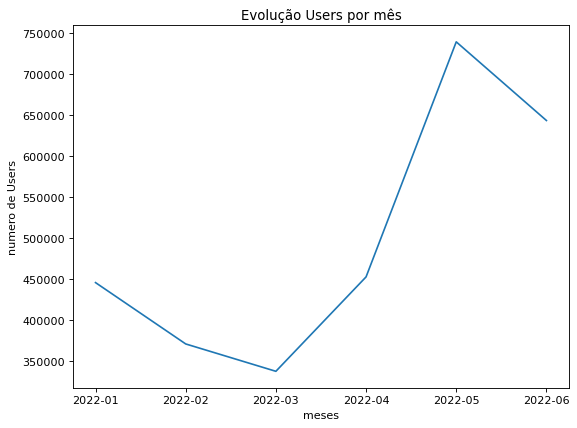

In [264]:
figure(figsize=(8, 6), dpi=80)
x = df_games_22_final['creation_date']
y = df_games_22_final['device_id']
plt.plot(x, y ) 
plt.xlabel("meses")  
plt.ylabel("numero de Users")  
plt.title("Evolução Users por mês")  
plt.show() 

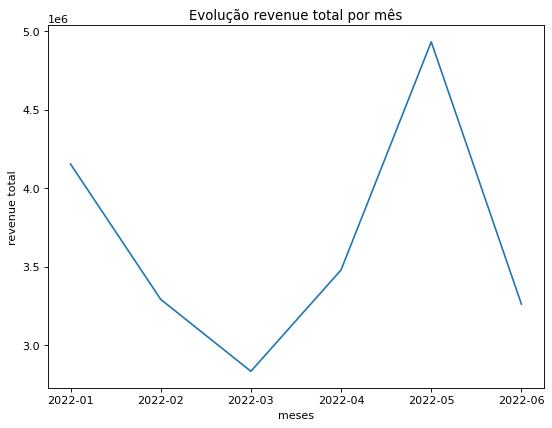

In [266]:
figure(figsize=(8, 6), dpi=80)
x = df_games_22_final['creation_date']
y = df_games_22_final['revenue_total']
plt.plot(x, y ) 
plt.xlabel("meses")  
plt.ylabel("revenue total")  
plt.title("Evolução revenue total por mês")  
plt.show() 

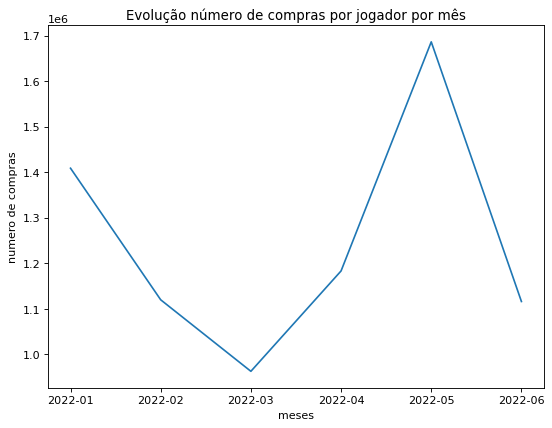

In [269]:
figure(figsize=(8, 6), dpi=80)
x = df_games_22_final['creation_date']
y = df_games_22_final['iap_purchases']
plt.plot(x, y ) 
plt.xlabel("meses")  
plt.ylabel("numero de compras")  
plt.title("Evolução número de compras por jogador por mês")  
plt.show() 

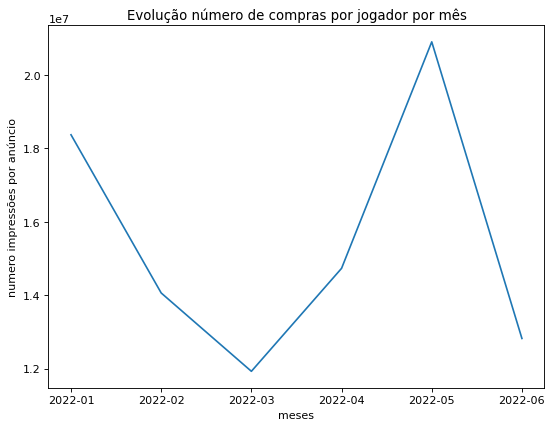

In [271]:
figure(figsize=(8, 6), dpi=80)
x = df_games_22_final['creation_date']
y = df_games_22_final['ad_impressions']
plt.plot(x, y ) 
plt.xlabel("meses")  
plt.ylabel("numero impressões por anúncio")  
plt.title("Evolução número de compras por jogador por mês")  
plt.show() 